In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#inspect measurement schema
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#inspect measurement schema
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
###Design a query to retrieve the last 12 months of precipitation data and plot the results
## Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)


('2017-08-23',)
2016-08-23


In [25]:
### Perform a query to retrieve the data and precipitation scores

precip_data = session.query(func.strftime("%Y-%m-%d", Measurement.date),Measurement.prcp).\
       filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).\
       group_by(Measurement.date).order_by(Measurement.date).all()


In [27]:
## Save the query results as a Pandas DataFrame and set the index to the date column

#load as a dataframe
precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#set index
precip_df.set_index('date', inplace = True)


precip_df


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


In [33]:
#len(precip_df)

filtered_df = precip_df[precip_df['precipitation'].isnull()]


filtered_df

,precipitation
date,
2016-09-05,NaN
2016-09-06,NaN


In [37]:
# Eliminar valores Nan

precip_df = precip_df.dropna()

len(precip_df)

364

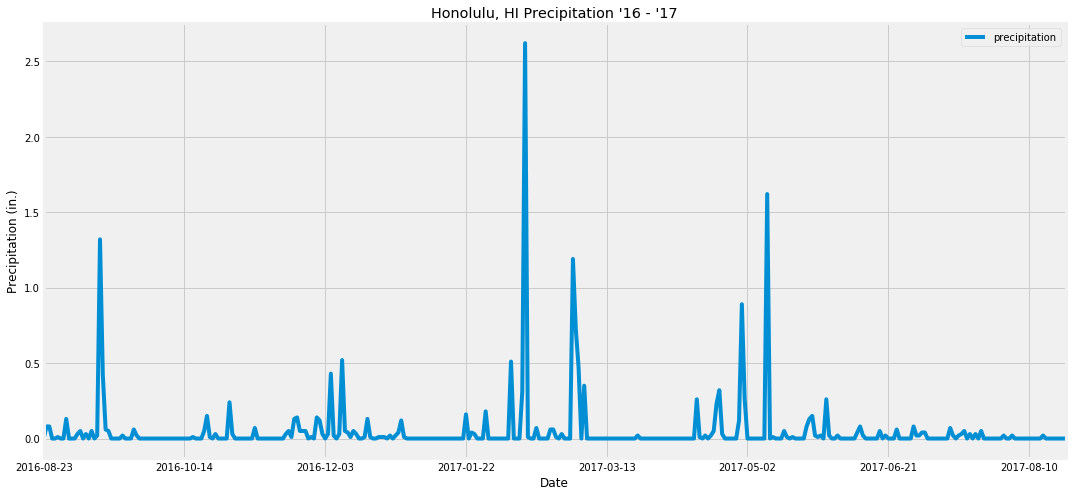

In [42]:
#plot data
fig, ax = plt.subplots(figsize = (15, 7))
precip_df.plot(ax = ax, x_compat = True)

#set title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Honolulu, HI Precipitation '16 - '17")

#save figure
plt.savefig("Images/precip.png")

#plot figure
plt.tight_layout()
plt.show()

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()


,precipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


# Exploratory Climate Analysis

In [44]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.id).distinct().count()
stations

9

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_counts = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
                 join(Station, Measurement.station == Station.station).group_by(Station.station).\
                 order_by(func.count(Measurement.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")


Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

print(f"-------------------------RESULTS--------------------------------")
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")


-------------------------RESULTS--------------------------------
Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [63]:
# Choose the station with the highest number of temperature observations.

#most_active_station = 'USC00519281'

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
               filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame

temps_df = pd.DataFrame(temps, columns = ['date', 'temperature'])
temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [64]:
#Set index by date

temps_df.set_index('date', inplace = True)


In [67]:
temps_df

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
2016-08-29,78.0
2016-08-30,77.0
2016-08-31,78.0


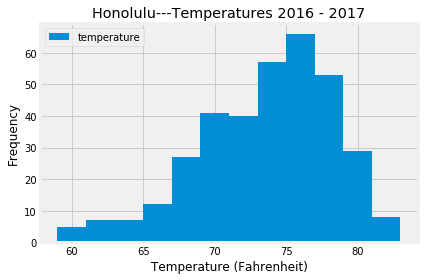

In [72]:
#plot histogram
fig, ax = plt.subplots()
temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu---Temperatures 2016 - 2017")

#save figure
plt.savefig("Images/temphist.png")

#plot
plt.tight_layout()
plt.show()

In [74]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [75]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps('2017-01-10', '2017-01-20')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit")
print(f"Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit")
print(f"Highest Temperature: {trip_temps[0][2]} Fahrenheit")


Lowest Temperature: 62.0 Fahrenheit
Average Temperature: 70.51 Fahrenheit
Highest Temperature: 81.0 Fahrenheit


In [78]:
trip_temps

[(62.0, 70.51470588235294, 81.0)]

In [80]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]

pk_to_pk
avg_temp

print(f"Peak to peak: {pk_to_pk} Fahrenheit")
print(f"Average temp: {avg_temp} Fahrenheit")


Peak to peak: 19.0 Fahrenheit
Average temp: 70.51470588235294 Fahrenheit


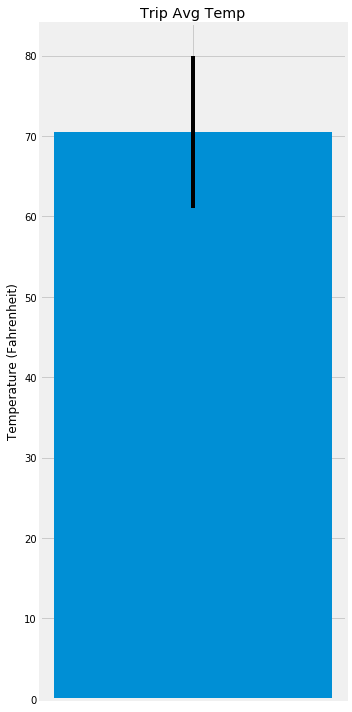

In [81]:
#plot figure
fig, ax = plt.subplots(figsize = (5, 10))

ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temperature (Fahrenheit)')

#save fig
plt.savefig("Images/tempbar")

#show figure
plt.tight_layout()
plt.show()

In [83]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


yearly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation, func.avg(Measurement.prcp)).\
                  filter(Measurement.station == Station.station).\
                  filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
                  order_by(func.avg(Measurement.prcp).desc()).all()

yearly_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.45064024390243923),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.19894886363636372),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.14142857142857151),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.12543396226415093),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.12105095541401273),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.044818941504178235)]

In [84]:
yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


## Optional Challenge Assignment

In [98]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [91]:
#create a list of dates

trip_dates = ["01-10", "01-11", "01-12", "01-13", "01-14", "01-15", "01-16", "01-17", "01-18", "01-19", "01-20"]

In [101]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


daily_norms = []

for x in trip_dates:
    day = {}
    day['Date'] = f"2019-{x}"
    daily_norm = daily_normals(x)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms



[{'Date': '2019-01-10', 'Min': 62.0, 'Avg': 69.74137931034483, 'Max': 77.0},
 {'Date': '2019-01-11', 'Min': 57.0, 'Avg': 67.3103448275862, 'Max': 78.0},
 {'Date': '2019-01-12', 'Min': 57.0, 'Avg': 67.4074074074074, 'Max': 81.0},
 {'Date': '2019-01-13', 'Min': 57.0, 'Avg': 67.25454545454545, 'Max': 77.0},
 {'Date': '2019-01-14', 'Min': 58.0, 'Avg': 69.52631578947368, 'Max': 77.0},
 {'Date': '2019-01-15', 'Min': 56.0, 'Avg': 69.31372549019608, 'Max': 78.0},
 {'Date': '2019-01-16', 'Min': 54.0, 'Avg': 68.62962962962963, 'Max': 80.0},
 {'Date': '2019-01-17', 'Min': 61.0, 'Avg': 69.07407407407408, 'Max': 76.0},
 {'Date': '2019-01-18', 'Min': 57.0, 'Avg': 68.63157894736842, 'Max': 77.0},
 {'Date': '2019-01-19', 'Min': 60.0, 'Avg': 68.26315789473684, 'Max': 78.0},
 {'Date': '2019-01-20', 'Min': 61.0, 'Avg': 68.86666666666666, 'Max': 78.0}]

In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#load into a data frame
daily_norms_df = pd.DataFrame(daily_norms)

#set index
daily_norms_df.set_index('Date', inplace = True)

#display
daily_norms_df


,Avg,Max,Min
Date,,,
2019-01-10,69.741379,77.0,62.0
2019-01-11,67.310345,78.0,57.0
2019-01-12,67.407407,81.0,57.0
2019-01-13,67.254545,77.0,57.0
2019-01-14,69.526316,77.0,58.0
2019-01-15,69.313725,78.0,56.0
2019-01-16,68.629630,80.0,54.0
2019-01-17,69.074074,76.0,61.0
2019-01-18,68.631579,77.0,57.0


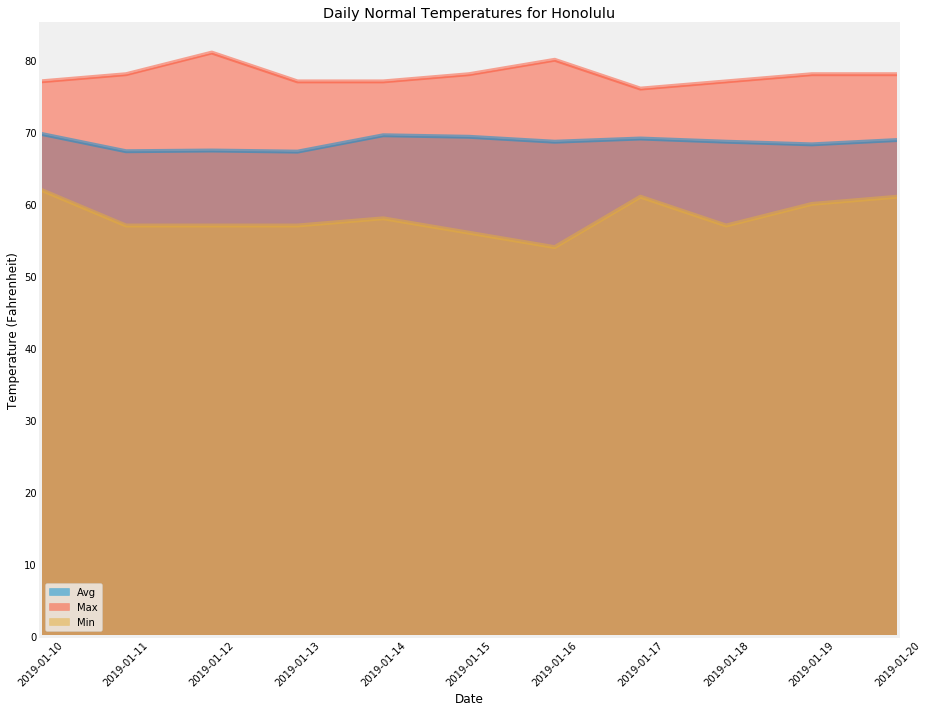

In [104]:
# Plot the daily normals as an area plot with `stacked=False`


fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynorm.png')

#show
plt.grid()
plt.tight_layout()
plt.show()
